In [9]:
import copy
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

p = re.compile('''([a-z\_]+),([\-0-9]+),([0-9]+),([0-9]+)''')
def select(table, subflow, key):
    flow = table.loc[table["flow_id"] == subflow]
    flow = flow.loc[flow['key'] == key]
    return flow
def read(file_name):
    with open(file_name) as json_file:
        message = json_file.read()

    result = p.finditer(message)
    i = 0
    temp = []
    for r in result:
        key = str(r.group(1))
        flow_id = int(r.group(2))
        flow_time = int(r.group(3))
        value = int(r.group(4))
        temp.append([flow_time, flow_id, key, value])

    table = pd.DataFrame(temp, columns=['time', 'flow_id', 'key', 'value'])
    temp = table[table['flow_id'] != 0]
    remove_id = temp['flow_id'].value_counts().keys()[2:]
    table = table.loc[table['flow_id'].isin(remove_id) == False]

    temp = table[table['flow_id'] != 0]
    subflow_id = temp.sort_values(["time"], ascending=[True])
    first_flow = subflow_id.iloc[0]['flow_id']
    table.loc[table['flow_id'] == 0, 'flow_id'] = 'meta'
    table.loc[table['flow_id'] == first_flow, 'flow_id'] = 'sub1'
    table.loc[(table['flow_id'] != 'meta') & (table['flow_id'] != 'sub1') , 'flow_id'] = 'sub2'

    min_time = table.loc[:,"time"].min()
    table.loc[:,"time"] = (table.loc[:,"time"] - min_time) / 250
        
    bins = []
    for i in range(0, 60000, 1000):
        bins.append(i / 1000)
    table = table.sort_values(["time"], ascending=[True])
    table.name = file_name
    option = []
    # throughput 계산
    for subflow in ['sub1', 'sub2']:
        flow = select(table, subflow, "send")
        trans = flow.groupby(pd.cut(flow['time'], bins=bins)).sum()
        y = [i / 1024 / 1024 for i in list(trans['value'])]
        
        flow = select(table, subflow, "retransmission")
        retransmission = flow.groupby(pd.cut(flow['time'], bins=bins)).sum()
        
        sent = 0
        for i in range(0, len(list(trans['value']))):
            sent += trans['value'][i]
            option.append([bins[i], subflow, 'throughput', y[i] * 10])
            option.append([bins[i], subflow, 'ret', retransmission['value'][i]])
            option.append([bins[i], subflow, 'total_bytes', sent])
            
    # total_bytes
    flow = table.loc[table['key'] == 'receive']
    trans = flow.groupby(pd.cut(flow['time'], bins=bins)).sum()
    sent = 0
    for i in range(0, len(list(trans['value']))):
        sent += trans['value'][i]
        option.append([i, 'meta', 'total_bytes', sent])
            
    temp = pd.DataFrame(option, columns=['time', 'flow_id', 'key', 'value'])
    table = table.append(temp)
    return table

def view(table, flow_id, key, time_s = 0, time_e = 30, color=0, label=None):
    if (label == None): label = flow_id
    flow = table.loc[table["flow_id"] == flow_id]
    flow = flow.loc[(flow['time'] > time_s) & (flow['time'] < time_e)]
    flow = flow.loc[flow['key'] == key]
    x = flow['time']
    y = flow["value"]

    nx = []
    ny = []
    for i in range(0,len(x)):
        nx.append(x.iloc[i])
        ny.append(y.iloc[i])
        
    colors = [['cornflowerblue', 'blue'],
             ['sandybrown', 'coral'],
             ['orchid', 'magenta']]
    plt.plot(nx, ny, linewidth=1,zorder=0, color=colors[color][0], label=label)
    plt.scatter(nx,ny, s=0.02, zorder=10, color=colors[color][1])
    plt.xlabel("Time (sec)")
    plt.ylabel(key)
    #plt.ylim(0,500)
    plt.title(flow_id + " " + key)
    
# 패킷 개수 확인
def packet_binning(table, flow_id, key, time_s = 0, time_e = 30, interval = 10):
    flow = table.loc[table["flow_id"] == flow_id]
    flow = flow.loc[(flow['time'] > time_s) & (flow['time'] < time_e)]
    flow = flow.loc[flow['key'] == key]
    bins = []
    for i in range(0,60000,interval):
        bins.append(i / 1000)
    trans = flow.groupby(pd.cut(flow['time'], bins=bins)).size()
    
    color="blue"
    
    if (flow_id=='sub2' or key=='receive'):
        color="orange"
    
    plt.plot(bins[:len(trans)], trans, c=color, linewidth=1)
    plt.xlabel("Time (sec)")
    plt.ylabel(key + ' Packets/' + interval + 'ms')
    plt.xlim(time_s, time_e)
    plt.show()
    


In [22]:
prefix = "logs2/iperf2bandwidth"
default = read(prefix + "_default.txt");
blest = read(prefix + "_blest.txt");
redundant = read(prefix + "_redundant.txt");
only_fast = read(prefix + "_only_fast.txt");
  

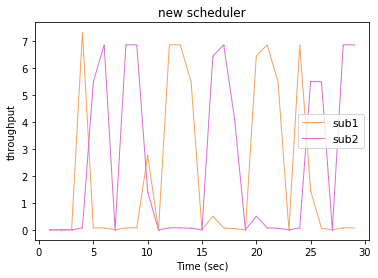

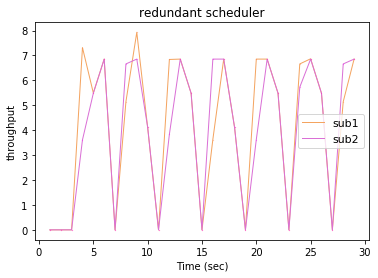

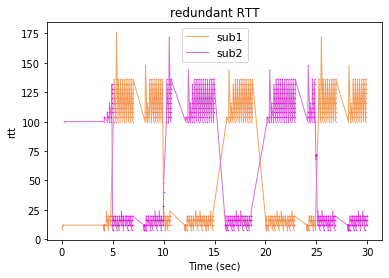

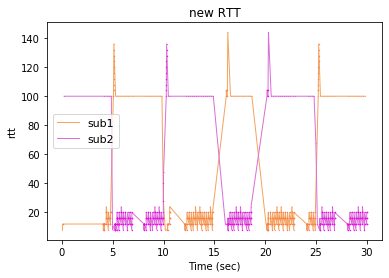

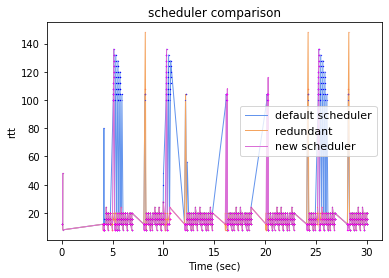

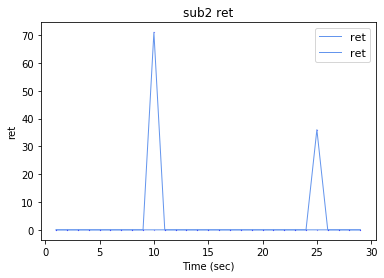

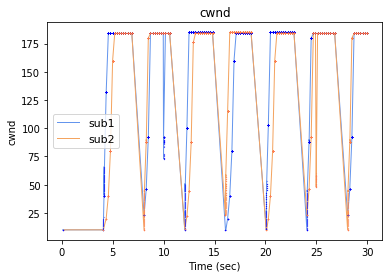

In [24]:
plt.figure(figsize=(6,4))
view(only_fast, 'sub1','throughput',0,30,1)   
view(only_fast, 'sub2','throughput',0,30,2)  
plt.title("new scheduler")
plt.legend(fontsize=11)
plt.show()

plt.figure(figsize=(6,4))
view(redundant, 'sub1','throughput',0,30,1)   
view(redundant, 'sub2','throughput',0,30,2)  
plt.title("redundant scheduler")
plt.legend(fontsize=11)
plt.show()


plt.figure(figsize=(6,4))
#view(redundant, 'meta','rtt',0,30,0)   
view(redundant, 'sub1','rtt',0,30,1)   
view(redundant, 'sub2','rtt',0,30,2)   
plt.title("redundant RTT")
plt.legend(fontsize=11)
plt.show()



plt.figure(figsize=(6,4))
#view(only_fast, 'meta','rtt',0,30,0)   
view(only_fast, 'sub1','rtt',0,30,1)   
view(only_fast, 'sub2','rtt',0,30,2)   
plt.title("new RTT")
plt.legend(fontsize=11)
plt.show()

plt.figure(figsize=(6,4))
view(default, 'meta','rtt',0,30,0, "default scheduler")   
view(redundant, 'meta','rtt',0,30,1, "redundant")   
view(only_fast, 'meta','rtt',0,30,2, "new scheduler")   
plt.title("scheduler comparison")
plt.legend(fontsize=11)
plt.show()

plt.figure(figsize=(6,4))
view(redundant, 'sub1','ret',0,30,0, "ret")   
view(redundant, 'sub2','ret',0,30,0, "ret")   
plt.legend(fontsize=11)
plt.show()

plt.figure(figsize=(6,4))
view(redundant, 'sub1','cwnd',0,30,0)   
view(redundant, 'sub2','cwnd',0,30,1)   
plt.title("cwnd")
plt.legend(fontsize=11)
plt.show()



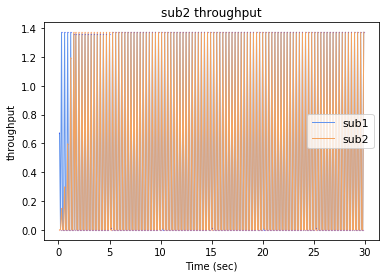

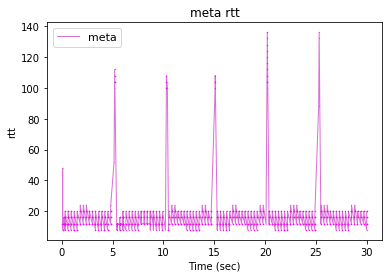

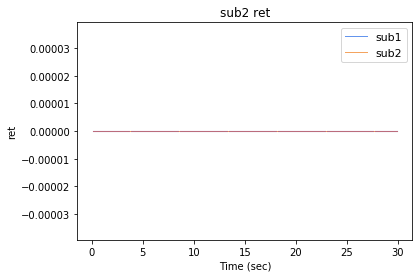

In [26]:
plt.figure(figsize=(6,4))
view(redundant, 'sub1','throughput',0,30,0)   
view(redundant, 'sub2','throughput',0,30,1)   
plt.legend(fontsize=11)
plt.show()


plt.figure(figsize=(6,4))
view(redundant, 'meta','rtt',0,30,2)   
plt.legend(fontsize=11)
plt.show()

plt.figure(figsize=(6,4))
view(redundant, 'sub1','ret',0,30,0)   
view(redundant, 'sub2','ret',0,30,1)   
plt.legend(fontsize=11)
plt.show()

In [10]:

view(messages, 'meta','rtt',0,30,0)  
plt.title("RTT")
plt.legend(fontsize=11)
plt.show()

NameError: name 'messages' is not defined

In [16]:
a = ["0.1", "0.005", "full"]
b = ["default", "blest", "redundant", "only_fast"]
for i in a:
    for j in b:
        read("logs/" + i + "_" + j + ".txt").to_csv()

FileNotFoundError: [Errno 2] No such file or directory: 'logs/0.1_default.txt'